In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from scipy.signal import lfilter
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import  plotly.graph_objects as go
import pandas as pd
from src.passband_modulations  import bpsk_mod,bpsk_demod
from src.channels import awgn
from src.essentials import plotWelchPSD 
from scipy.special import erfc

<img src="Figs/fga.png" alt="isolated"/>

<h1 style="text-align: center;"> Simulação de Transmissões Digitais </h1>

<h3 style="text-align: center;">Disciplina: Comunicações Digitais para Engenaharia</h3>


<p style="text-align: center;">Prof. Daniel C. Araújo</p>

## Conteúdo

1. Modulador e Demodulador BPSK

# Modulador e Demodulador BPSK

## Arquitetura do transmissor

Como estudado anteriormente, os sinais de saída do transmissor BPSK são

$$
\begin{align*}
   s_1(t)   & = A \cos (2 \pi f_c t),   \,\ 0 \leq t \leq T_b \\
   s_2(t)   & = A \cos (2 \pi f_c t + \pi), \,\ 0 \leq t \leq T_b
\end{align*}
$$


<img src="Figs/mod_digi/bpsk_mod.png" alt="isolated"/>

## Implementação em python
```{python}
import numpy as np
from scipy.signal import upfirdn
def bpsk_mod(ak, L):

   

    '''
    Function to modulate an incoming bindry stream using BPSK (baseband)
    Parameters:
        ak: input binary data stream (0s and 1s) to modulate
        L: oversampling factor (Tb/Ts)
    Returns:
        (s_bb,t): tuple of following variables
            s_bb: BPSK modulated signal (baseband) -- s_bb(t)
            t: generated time base for modulated signal
    '''

    s_bb = upfirdn(h=[1]*L, x=2*ak-1, up=L) # NRZ encoder (+1V for 1 and -1V for 0)
    t=np.arange(0, len(ak)*L) # discrete time base

    return (s_bb, t)
```

> importante: Todos os códigos podem ser obtidos no [link](https://github.com/tcoulon19/DigitalModulationsUsingPython.git)

## Sinal recebido

O processo de demodulação é sempre desafiador. O sinal recebido é distorcido pelo canal comunicação e combinado com a adição do ruído, como mostra a expressão

$$
r(t) = h(t) \circ s_m(t) + n(t)
$$
em que $n(t)$ é o ruído e $h(t)$ é o canal. 

* O objetivo nesse primeiro momento é avaliar o impacto do ruído no processo de demodulação, portanto iremos remover a influência do ruído. Em um segundo momento do curso iremos tratar o canal.
  $$
  h(t) = \delta (t)
  $$

Caracterização do ruído
* Processo aleatório 
* Distribui Gaussiana
* Densidade espectral de potência $\frac{N_0}{2}$

> Importante: Esse modelo é conhecido com AWGN (Aditive White Gaussian Noise)

## Implementação do canal

```{python}
def awgn(s,SNRdB,L=1):

    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    Parameters:
    s : input/transmitted signal vector
    SNRdB : desired signal to noise ratio (expressed in dB)
    for the received signal
    L : oversampling factor (applicable for waveform simulation)
    default L = 1.
    Returns:
    r : received signal vector (r=s+n)
    """

    gamma = 10**(SNRdB/10) #SNR to linear scale

    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    
    r = s + n # received signal
    
    return r
```

## Digrama de bloco do Demodulador



<img src="Figs/mod_digi/bpsk_demod.png" alt="isolated"/>

## Implementação em python 

```{python}
def bpsk_demod(r_bb, L):

    import numpy as np

    '''
    Function to demodulate a BPSK (baseband) signal
    Parameters:
        r_bb: received signal at the receiver front end (baseband)
        L: oversampling factor (Tsym/Ts)
    Returns:
        ak_hat: detected/estimated binary stream
    '''

    x = np.real(r_bb) # I arm
    x = np.convolve(x, np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    
    return ak_hat 


```

## Simulação fim-a-fim


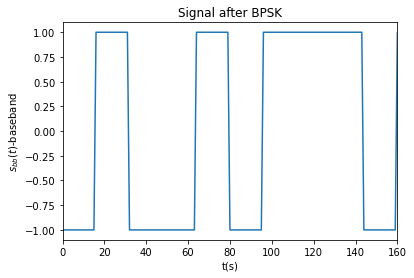

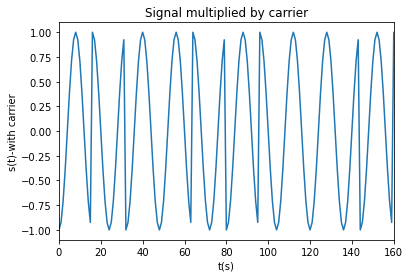

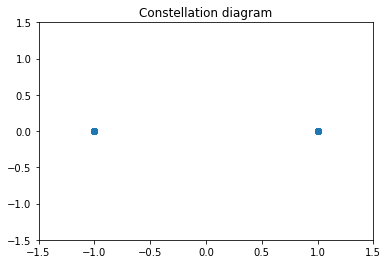

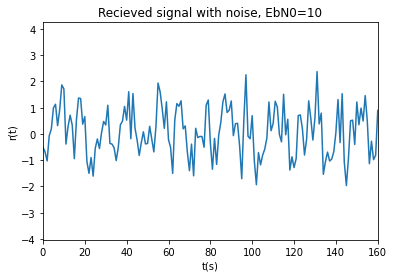

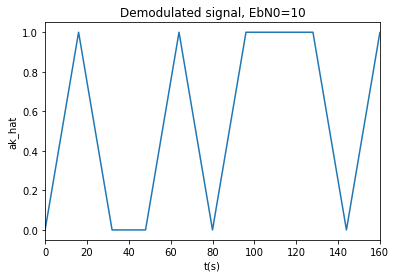

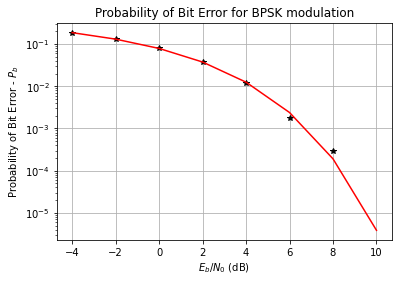

In [8]:
def BPSK_performance(N):

     

        #N=10000 # Number of symbols to transmit
        EbN0dB = np.arange(-4,11,2) # Eb/N0 range in dB for simulation
        L=16 # Oversampling factor, L = Tb/Ts (Tb = bit period, Ts = sampling period)
        # If carrier is used, use L = Fs/Fc, where Fs >> 2xFc
        Fc = 800 # Carrier frequency
        Fs = L*Fc # Sampling frequency
        BER = np.zeros(len(EbN0dB)) # For BER values for each Eb/N0
        ak = np.random.randint(2, size=N) # Uniform random symbols from 0s and 1s
        (s_bb, t) = bpsk_mod(ak,L) # BPSK modulation (waveform) - baseband
        s = s_bb*np.cos(2*np.pi*Fc*t/Fs) # With carrier
        # Waveforms at the transmitter
        
        plt.figure(0)
        plt.clf()
        plt.plot(t, s_bb) # Baseband wfm zoomed to first 10 bits
        plt.xlabel('t(s)')
        plt.ylabel('$s_{bb}(t)$-baseband')
        plt.xlim(0,10*L)
        plt.title('Signal after BPSK')
        #plt.savefig('Ch2_images/BPSK_performance_im1.png')

        plt.figure(1)
        plt.clf()
        plt.plot(t, s) # Transmitted wfm zoomed to first 10 bits
        plt.xlabel('t(s)')
        plt.ylabel('s(t)-with carrier')
        plt.xlim(0,10*L)
        plt.title('Signal multiplied by carrier')
        #plt.savefig('Ch2_images/BPSK_performance_im2.png')

        plt.figure(2)
        plt.clf()
        plt.plot(np.real(s_bb), np.imag(s_bb), 'o')
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title('Constellation diagram')
        #plt.savefig('Ch2_images/BPSK_performance_im3.png')

        for i,EbN0 in enumerate(EbN0dB):
            
            # Compute and add AWGN noise
            r = awgn(s, EbN0, L) # Refer Chapter section 4.1

            r_bb = r*np.cos(2*np.pi*Fc*t/Fs) # Recovered baseband signal
            ak_hat = bpsk_demod(r_bb, L) # Baseband correlation demodulator
            BER[i] = np.sum(ak != ak_hat)/N # Bit Error Rate Computation (!= means "not equal to")

            # Received signal waveform zoomed to first 10 bits, EbN0dB=9
            if EbN0 == 10:

                plt.figure(3)
                plt.clf()
                plt.plot(t,r)
                plt.xlabel('t(s)')
                plt.ylabel('r(t)')
                plt.xlim(0,10*L)
                plt.title('Recieved signal with noise, EbN0=10')
                #plt.savefig('Ch2_images/BPSK_performance_im4.png')

                plt.figure(4)
                plt.clf()
                plt.plot(16*np.arange(N),ak_hat)
                plt.xlabel('t(s)')
                plt.ylabel('ak_hat')
                plt.xlim(0,10*L)
                plt.title('Demodulated signal, EbN0=10')
                #plt.savefig('Ch2_images/BPSK_performance_im5.png')

        #----------Theoretical Bit/Symbol Error Rates----------
        theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # Theoretical bit error rate
        
        #----------Plots----------
        plt.figure(5)
        plt.clf()
        plt.semilogy(EbN0dB, BER, 'k*', label='Simulated') # Simulated BER
        plt.semilogy(EbN0dB, theoreticalBER, 'r-', label='Theoretical')
        plt.xlabel('$E_b/N_0$ (dB)')
        plt.ylabel('Probability of Bit Error - $P_b$')
        plt.grid()
        plt.title('Probability of Bit Error for BPSK modulation')
        #plt.savefig('Ch2_images/BPSK_performance_im6.png')

BPSK_performance(10000)